# Сжатие языковой модели

## Порядок сдачи домашнего

Под каждое домашнее вы создаете отдельную ветку куда вносите все изменения в рамках домашнего. Как только домашнее готово - создаете пулл реквест (обратите внимание что в пулл реквесте должны быть отражены все изменения в рамках домашнего). Ревьювера назначаете из таблицы - https://docs.google.com/spreadsheets/d/1vK6IgEqaqXniUJAQOOspiL_tx3EYTSXW1cUrMHAZFr8/edit?gid=0#gid=0
Перед сдачей проверьте код, напишите тесты. Не забудьте про PEP8, например, с помощью flake8. Задание нужно делать в jupyter notebook.

**Дедлайн - 17 октбяря 10:00**

В этом домашнем задании вам предстоит изучить и реализовать комбинированный алгоритм для сжатия матриц весов языковой модели, который включает три этапа: 
- **Квантизацию**
- **Кодирование Хаффмана**
- **Бит-паккинг**
- **Запись и чтение в файл**

Вам также необходимо будет реализовать обратную процедуру расжатия для восстановления матрицы до её исходного состояния. Пакетом `numpy` пользовать нельзя.

Для начала сгенерируем нашу матрицу весов. Реализуйте функцию `generate_normal_weights_matrix`, которая будет генерировать матрицу случайных весов, где веса распределены нормально. Вам понадобится функция `random.gauss` для генерации случайных чисел из нормального распределения:

In [1]:
import random

mean = 0.0
stddev = 0.1
random.gauss(mean, stddev)

-0.05009995767906672

```python
weights_matrix = generate_normal_weights_matrix(5, 5)
for row in weights_matrix:
    print(row)
[0.3000485326712691, 0.25965299191334695, -0.06755153631842248, 0.13020487844655038, 0.1143769419370928]
[0.04287032494033407, 0.37860865986969466, -0.21154587156719093, 0.02538857794887883, 0.358874552698265]
[-0.12730102686770312, -0.09250783210681686, -0.31943991155969786, -0.12649930568136855, -0.133368865014227]
[-0.001125940850390421, 0.08131363950833258, -0.12099869191945688, 0.14554258117597563, 0.157276907472140]
[-0.07352639207896368, 0.013629438616873364, -0.11502982664385775, 0.042140678513802377, 0.0980238501942050]
```

In [2]:
def generate_normal_weights_matrix(rows, cols, mean=0.0, stddev=0.1):
    matrix = []
    for row in range(rows):
        row_of_matrix = []
        for col in range(cols):
            row_of_matrix.append(random.gauss(mean, stddev))
        matrix.append(row_of_matrix)
    return matrix

generate_normal_weights_matrix(3, 3, mean=0.0, stddev=0.1)

[[-0.06118536337427352, 0.008735944869801815, -0.2732716304988366],
 [0.04982639157243188, 0.1480750470967546, 0.09822189393360181],
 [-0.17843427507304271, -0.017718012962700515, 0.006615074374080475]]

In [3]:
def generate_normal_weights_matrix(rows, cols, mean=0.0, stddev=0.1):
    return [[random.gauss(mean, stddev) for _ in range(cols)] for _ in range(rows)]

generate_normal_weights_matrix(3, 3, mean=0.0, stddev=0.1)

[[0.0390787576629974, -0.12097994936874, 0.09853505313105937],
 [-0.05513333134791426, 0.1891020315275256, 0.2280344006375363],
 [-0.1656399330228038, -0.04230780433384752, 0.02953224161969688]]

Для упрощения работы переведем двух мерный массив в одномерный.

In [4]:
weights_matrix = generate_normal_weights_matrix(100, 100, mean, stddev)

In [ ]:
weights = [weight for row in weights_matrix for weight in row]
print(weights)

[-0.08964608554065503, -0.08012046555610543, 0.05105521745640232, -0.05864794463271146, 0.09650589490147343, 0.06070189075742512, 0.15727004170093203, 0.04656644638326892, 0.235348487606869, -0.04804997478925538, -0.03749944556624431, 0.09192867756862369, -0.03177398874357554, 0.07459971729058339, 0.16993268523848265, -0.0660329076565231, -0.0005899693316875291, -0.03828641737820258, 0.03267633824365104, 0.0664460728775445, -0.002122542206602733, -0.01566900989408763, -0.01343497495181405, -0.08749493958507651, -0.05422782314660283, -0.0573201619880674, -0.06341220877655868, -0.00796293746313251, 0.11073003608286576, -0.12715613624831498, 0.04869304217391753, 0.011822882715087073, 0.047253159828739455, 0.16320174274307153, 0.1353909011095861, -0.06641872157422345, -0.05494696291155421, 0.06119079965314605, -0.07511864676964931, -0.10136569035847375, 0.025748293853624954, 0.0741679035048832, -0.011727926722694175, -0.002176037028611374, -0.004712571728212017, -0.1096049703019782, -0.071

Проверим, что у нас получилось.

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


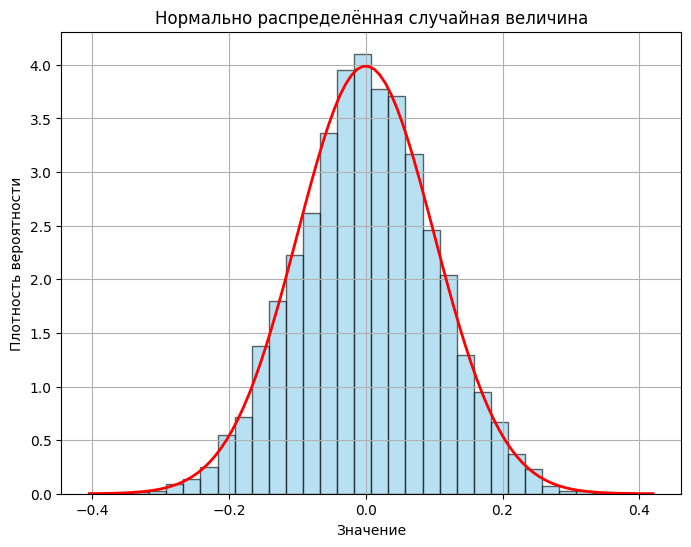

In [6]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(weights, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Добавление кривой плотности вероятности
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, stddev)  # Вычисление плотности вероятности
plt.plot(x, p, 'r', linewidth=2)

# Настройки графика
plt.title("Нормально распределённая случайная величина")
plt.xlabel("Значение")
plt.ylabel("Плотность вероятности")
plt.grid(True)

# Отображение графика
plt.show()

Приступим к сжатию этой матрицы!

## Квантизация

**Квантизация** — это процесс преобразования данных с высокой точностью (например, с 32-битного представления) в данные с более низкой точностью (например, 8-битное представление) для уменьшения объёма памяти и вычислительных ресурсов. В контексте машинного обучения, квантизация чаще всего применяется к весам нейронных сетей и их активациям для уменьшения размера модели и ускорения работы, особенно при выполнении инференса на мобильных устройствах и встраиваемых системах.


### Цели квантизации:

1.	**Уменьшение объёма памяти:** Квантизация позволяет сократить объём памяти, занимаемый весами и другими параметрами модели, путём представления чисел с меньшей разрядностью.
2.	**Ускорение вычислений:** С помощью квантизации можно использовать специальные процессоры и ускорители (например, процессоры с поддержкой 8-битных вычислений), что увеличивает производительность.
3.	**Снижение энергопотребления:** Более короткие представления данных позволяют сократить энергопотребление при выполнении операций.

### Как работает квантизация?

Квантизация заключается в преобразовании значений с высокой точностью (например, числа с плавающей точкой) в числа с меньшей точностью (например, целые числа). Существует несколько методов квантизации:

1.	**Униформная (равномерная) квантизация:** Простая и часто используемая техника, когда диапазон значений разделяется на равные интервалы (кванты), и каждое значение округляется до ближайшего значения из этого интервала.
2.	**Неравномерная квантизация:** Применяется, когда диапазон значений распределён неравномерно, и поэтому используются интервалы с разной шириной.
3.	**Квантизация во время обучения (quantization-aware training):** Модель обучается с учётом того, что её веса будут квантизированы. Это позволяет лучше подготовить модель к работе в условиях низкой точности.
4.	**Квантизация после обучения (post-training quantization):** Модель сначала обучается с полной точностью, а затем веса и активации квантизируются.

В данном домашнем задании мы рассмотри наиболее простой вариант - **равномерная квантизация**.

### Пример униформной квантизации

Предположим, у нас есть матрица весов, представленная в виде чисел с плавающей точкой, и мы хотим сократить количество бит, используемых для хранения этих значений.

#### Шаг 1: Определение диапазона значений

Для начала определим минимальное и максимальное значение весов, чтобы определить диапазон:

In [7]:
min_value = min(weights)
max_value = max(weights)

print(f"Минимальное значение: {min_value}")
print(f"Максимальное значение: {max_value}")

Минимальное значение: -0.366640519715963
Максимальное значение: 0.38267977668897923


#### Шаг 2: Определение шага квантизации

Теперь мы определим шаг квантизации, который будет разделять диапазон на равные интервалы. Предположим, что мы хотим использовать 8-битное представление. Это даёт нам $256$ различных значений (так как $8$ бит позволяют хранить $2^8 = 256$ различных чисел).

Шаг квантизации можно вычислить как:


$$\text{step} = \frac{\max - \min}{2^8 - 1}$$


In [8]:
num_levels = 256  # Для 8 бит
step = (max_value - min_value) / (num_levels - 1)
print(f"Шаг квантизации: {step}")

Шаг квантизации: 0.0029385109662938913


#### Шаг 3: Применение квантизации

Теперь мы можем преобразовать каждое значение в его ближайший квантизированный уровень:


$$\text{quantized_value} = \text{round} \left( \frac{\text{value} - \min}{\text{step}} \right)$$


In [9]:
quantized_weights = [round((weight - min_value) / step) for weight in weights]

print("Квантизированные веса:")
print(set(quantized_weights))

Квантизированные веса:
{0, 11, 13, 14, 16, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 223, 224, 225, 230, 232, 234, 236, 244, 

#### Шаг 4: Обратное преобразование (деквантизация)

Чтобы восстановить оригинальные значения весов, необходимо преобразовать квантизированные значения обратно в их исходный диапазон:


$$\text{recovered_value} = \text{quantized_value} \times \text{step} + \min$$


In [10]:
recovered_weights = [quantized_weight * step + min_value for quantized_weight in quantized_weights]

print("Восстановленные веса:")
print(recovered_weights[:5])

Восстановленные веса:
[-0.09042048888433724, -0.07866644501916165, 0.05062803749776956, -0.058096868255104406, 0.09764421295847181]


Посчитаем максимальную ошибку

In [11]:
max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])

0.0014690831657980623

На практике намного удобнее, когда мы можем контролировать ошибку, поэтому реализуйте методы квантизации и деквантизации, у которых будет параметр максимальной возможной ошибки между значениями для задания `step`.

In [12]:
def quantize_weights(weights, max_error):
    step = 2 * max_error
    min_value = min(weights)
    quantized_weights = [round((weight - min_value) / step) for weight in weights]
    return quantized_weights, step, min_value


def dequantize_weights(quantized_weights, step, min_value):
    return [quantized_weight * step + min_value for quantized_weight in quantized_weights]


In [13]:
max_error = 0.01
quantized_weights, step, min_value = quantize_weights(weights, max_error)
recovered_weights = dequantize_weights(quantized_weights, step, min_value)
print(quantized_weights, step, min_value)
print(recovered_weights)

[14, 14, 21, 15, 23, 21, 26, 21, 30, 16, 16, 23, 17, 22, 27, 15, 18, 16, 20, 22, 18, 18, 18, 14, 16, 15, 15, 18, 24, 12, 21, 19, 21, 26, 25, 15, 16, 21, 15, 13, 20, 22, 18, 18, 18, 13, 15, 24, 22, 20, 17, 17, 19, 19, 21, 12, 21, 25, 25, 10, 12, 16, 9, 18, 12, 21, 23, 20, 21, 23, 16, 17, 17, 14, 14, 16, 18, 24, 21, 19, 10, 24, 22, 19, 17, 29, 21, 11, 17, 23, 25, 8, 15, 18, 17, 10, 15, 20, 11, 22, 24, 19, 20, 17, 19, 28, 12, 16, 18, 12, 28, 18, 18, 20, 10, 20, 20, 11, 15, 19, 13, 13, 7, 23, 19, 18, 17, 13, 18, 20, 12, 22, 12, 17, 17, 21, 26, 20, 16, 16, 15, 19, 21, 24, 15, 21, 21, 16, 15, 20, 18, 16, 21, 24, 18, 25, 14, 13, 18, 26, 21, 18, 17, 20, 15, 24, 20, 13, 15, 19, 14, 17, 24, 13, 20, 19, 25, 22, 22, 13, 20, 16, 16, 18, 25, 20, 20, 18, 14, 23, 16, 12, 17, 11, 17, 21, 12, 21, 20, 13, 29, 14, 18, 23, 16, 12, 16, 18, 21, 16, 24, 23, 22, 15, 0, 15, 21, 24, 21, 10, 10, 3, 15, 16, 20, 22, 22, 17, 26, 12, 15, 20, 12, 16, 25, 15, 18, 17, 19, 18, 20, 11, 14, 18, 18, 20, 15, 18, 12, 22, 19, 

## Кодирование Хаффмана

**Кодирование Хаффмана** — это алгоритм сжатия данных, который используется для минимизации количества бит, необходимых для представления данных. Алгоритм Хаффмана является типом префиксного кодирования, где каждому символу данных назначается уникальная двоичная строка (код), и никакой код не является префиксом другого кода.

Этот метод особенно полезен, когда некоторые символы встречаются чаще других. Хаффмановское кодирование назначает более короткие коды для часто встречающихся символов и более длинные коды для редких символов, что позволяет сжимать данные без потерь.

Основные характеристики кодирования Хаффмана:

- **Префиксный код:** никакой код не является префиксом другого кода, что позволяет однозначно декодировать последовательность.
- **Оптимальность:** алгоритм Хаффмана даёт минимальную длину кодов для символов при известной частоте их появления.
- **Дерево Хаффмана:** строится на основе частот символов, где часто встречающиеся символы находятся ближе к корню дерева.


### Этапы работы алгоритма Хаффмана:

1.	**Подсчёт частот:** На первом шаге подсчитывается, как часто каждый символ встречается в данных.
2.	**Построение дерева Хаффмана:** Используя частоты символов, строится бинарное дерево. Символы с меньшими частотами располагаются дальше от корня дерева, а символы с более высокими частотами — ближе.
3.	**Назначение кодов:** Проходя от корня дерева к каждому листу (символу), алгоритм назначает каждому символу код: левой ветви присваивается “0”, а правой ветви — “1”. Таким образом, для каждого символа формируется уникальная двоичная строка.
4.	**Сжатие данных:** После того как к каждому символу присвоен код, данные можно сжать, заменив символы на соответствующие двоичные коды.
5.	**Декодирование:** Для восстановления исходных данных декодирование выполняется путём чтения двоичной строки и перемещения по дереву Хаффмана от корня до символа, который закодирован.

### Пример работы алгоритма Хаффмана

Рассмотрим, как кодирование Хаффмана может быть применено к строке “ABRACADABRA”.

**1.	Частоты символов:**
Подсчитаем частоты каждого символа в строке:
```python
A: 5
B: 2
R: 2
C: 1
D: 1
```

**2. Построение дерева Хаффмана:**
- Начнем с того, что каждый символ представляется в виде узла дерева с весом, равным частоте появления символа.
- На каждом шаге выбираются два узла с наименьшими частотами и объединяются в новый узел, вес которого равен сумме частот двух выбранных узлов. Этот процесс повторяется до тех пор, пока не будет построено одно дерево.

Строим дерево Хаффмана:
```python
Шаг 1:   C:1  D:1 -> 2 (левое поддерево: C, правое поддерево: D)
Шаг 2:   B:2  R:2 -> 4 (левое поддерево: B, правое поддерево: R)
Шаг 3:   2 (CD)  4 (BR) -> 6
Шаг 4:   A:5  6 (CD, BR) -> 11
```

Окончательное дерево Хаффмана выглядит следующим образом:

```python
      11
     /  \
    A    6
        /  \
      CD    BR
      / \   / \
     C   D B   R
```

**3.	Назначение кодов:**
Теперь присвоим каждому символу код, начиная от корня дерева:
- A: 0
- C: 100
- D: 101
- B: 110
- R: 111

**4. Сжатие строки:**
Используя полученные коды, мы можем закодировать строку “ABRACADABRA”:
```python
A -> 0
B -> 110
R -> 111
A -> 0
C -> 100
A -> 0
D -> 101
A -> 0
B -> 110
R -> 111
A -> 0
```

Закодированная строка: 0110111001000101101110

Реализуйте методы `huffman_encode` и `huffman_decode` для кодирования и декодирования с помощью алгоритма Хаффмана.

In [14]:
def huffman_encode(data):
    data = [str(item) for item in data]

    def count_simbols(data):
        simb = {sim: data.count(sim) for sim in set(data)}
        simb = dict(sorted(simb.items(), key=lambda item: item[1]))
        simb_max = next(iter(simb.items()))
        sum_count = sum(simb.values())
        return simb, simb_max, sum_count
    
    def pair_dic(simb):
        simb_con = simb.copy()
        list_simb = list(simb.items())
        while len(list_simb) > 1:
            list_simb = list(sorted(list_simb, key=lambda x: (x[1], len(str(x[0])))))
            simb_con[list_simb[0][0]+list_simb[1][0]] = list_simb[0][1] + list_simb[1][1]
            list_simb.append((list_simb[0][0]+list_simb[1][0], list_simb[0][1] + list_simb[1][1]))
            del list_simb[:2]
        simb_con = dict(sorted(simb_con.items(), key=lambda item: item[1], reverse=True))
        return simb_con

    def simb_encoding(simb_con, simb):
        for s in simb.keys():
            simb[s] = ""
            list_of_matches = [m for m in simb_con.keys() if str(s) in str(m)]
            list_of_matches.sort(key=lambda x: len(str(x)))
            for m in range(len(list_of_matches)-1):
                if str(list_of_matches[m+1]).startswith(str(list_of_matches[m])):
                    simb[s] = "0" + simb[s]
                else:
                    simb[s] = "1" + simb[s]
        return simb
    
    def final_encoding(simb, data):
        encoded_data = ''
        data_list = list(data)
        for w in data_list:
            encoded_data += simb[w]
        return encoded_data, simb
    
    simb, simb_max, sum_count = count_simbols(data)
    simb_con = pair_dic(simb)
    simb_encoding(simb_con, simb)
    encoded_data, huff_dict = final_encoding(simb, data)
    return encoded_data, huff_dict

def huffman_decode(encoded_data, huff_dict):
    decoded_data = []
    bits = ""
    for bit in encoded_data:
        bits += bit
        for key, value in huff_dict.items():
            if bits == value:
                try:
                    decoded_data.append(int(key))
                except ValueError:
                    try:
                        decoded_data.append(float(key))
                    except ValueError:
                        decoded_data.append(key)
                bits = ""
                break
    return decoded_data


data = "ABRACADABRA"
encoded_data, huff_dict = huffman_encode(data)
print(f"Закодированные данные: {encoded_data}")
# Закодированные данные: 01101001110011110110100

decoded_data = huffman_decode(encoded_data, huff_dict)
print(f"Декодированные данные: {decoded_data}")
# Декодированные данные: ABRACADABRA

Закодированные данные: 01101110100010101101110
Декодированные данные: ['A', 'B', 'R', 'A', 'C', 'A', 'D', 'A', 'B', 'R', 'A']


#### Посчитаем Хаффмана на наших квантизированных весах

In [15]:
encoded_data, huffman_dict = huffman_encode(quantized_weights)
encoded_data
decoded_data = huffman_decode(encoded_data, huffman_dict)
decoded_data

[14, 14, 21, 15, 10, 18, 30, 18]

## Бит пакинг

**Бит-паккинг (bit-packing)** — это техника сжатия данных, при которой несколько чисел или символов, представленных в виде бит, “упаковываются” в одно или несколько целых чисел (байтов или слов) с целью минимизировать занимаемую память. Этот метод особенно эффективен, если числа или коды занимают меньше бит, чем стандартный размер ячейки памяти (например, 8 бит для байта или 32 бит для целого числа).


### Основная идея:

Если каждая единица данных (например, число или символ) требует меньше бит, чем стандартная ячейка памяти, можно “упаковать” несколько таких единиц данных в одну ячейку, чтобы избежать потерь памяти на неиспользуемые биты. Это позволяет эффективно использовать пространство памяти и уменьшить общий объём данных.

### Пример использования бит-паккинга после кодирования Хаффмана

После кодирования Хаффмана символы данных преобразуются в коды разной длины (в битах). Например, для часто встречающихся символов коды будут короткими (например, 2 или 3 бита), а для редких символов — длинными (например, 6 или 7 бит). Однако стандартные структуры данных Python (например, массивы байтов) используют 8-битные ячейки памяти, что может привести к неэффективному использованию памяти, если не применить бит-паккинг.

### Почему бит-паккинг полезен после кодирования Хаффмана?

После кодирования Хаффмана мы получаем строку из 0 и 1 разной длины для каждого символа. Например:
```python
A -> 0
B -> 110
C -> 1001
```

Закодированная строка после Хаффмана может выглядеть так: 011011001. Если мы будем хранить эту строку побитно в стандартных байтах, это может занять больше места, чем нужно, так как каждый символ по умолчанию занимает 8 бит. Однако с помощью бит-паккинга можно эффективно “упаковать” эти коды в минимально возможное количество байтов.

### Пример

Предположим, у нас есть коды:

```python
A -> 0 (1 бит)
B -> 110 (3 бита)
C -> 1001 (4 бита)
```

После кодирования строки “AABAC”, мы получаем последовательность бит: 0110110011001. Данная строка может быть запакована в 2 байта:
- В первом байте хранится значение 01101101 (первые 8 бит).
- Во втором байте хранится значение 10011000 (оставшиеся 5 бит и заполненные нулями).

Реализуйте функцию `bit_packing`, которая упаковывает входную битовую строку в набор байт.

```python
encoded_data = "0110110011001"
packed_data = bit_packing(encoded_data)

print(f"Упакованные данные: {packed_data}")
Упакованные данные: b'l\xc8'
print(f"Длина упакованных данных: {len(packed_data)} байт")
Длина упакованных данных: 2 байт
```

In [16]:
def bit_packing(bit_string):
    bit_string_moved = bit_string.ljust((len(bit_string) + 7) // 8 * 8, '0')
    packed_data = int(bit_string_moved, 2).to_bytes(len(bit_string_moved) // 8, byteorder='big') 
    return packed_data

Реализуйте функцию `bit_unpacking`, которая распаковывет набор байт в битовую строку.
```python
unpacked_data = bit_unpacking(packed_data)
print(f"Распакованные данные: {unpacked_data}")
Распакованные данные: 0110110011001000
```

In [17]:
def bit_unpacking(packed_data):
    unpacked_bit_string = ''.join(f'{byte:08b}' for byte in packed_data)
    return unpacked_bit_string

#### Теперь запакуем закодированные данные

In [18]:
packed_data = bit_packing(encoded_data)
packed_data

b'D\x96]\xf2\xbeIZ\xa5\xdf\xcey7\xd5\xb9\xff\xfaS7\x87\xac\xec\xaf\x91j\x96\x1bs\xff\xf1`s\xbe\xed\xd9\xf5\x98\xc5w\xd6\xb3\x7f\xeb+\xbe\xe5w\xd7r%xN\xae\x83\x9e\xf6i\x87.\xf8\xaf\xdfo\xe5\xd6\xb89\x86\xdfj\xde\xb5\xfe\xab\x7f\xda\xed\xdc\x1bDW\xbf\xff\xf5\xdf\xbf\xc3\xf7\xea\xe7\xeb\xdd+\xe5\xd56\xc84\xcd5\xfdH|P}|\x9f\xeb`\xb1mN\x01\xbd\x8b\x9b\x98\xddW\xc6\xef\xd1w\xd7\xafC\xa7\xd6ls\'\xae\xfa\xf5\xaf\x9a\x05\xde\xe6\xcb\xdf\x7f\xdaBWWW\x7f\xff\xff\xf6\xabss\xe5\xf3\xd5\xaf\xd6\xa2\xdf\xdb\xf7\x04\xff\xb6\xffW=\x84\xcd/\x7f\xffs\xdfq]s]\xeb\xe6\xc2\xfdki\xcdw\xcaj\xd2\xe6\xe7\xfa\xbd\xff\xff\xd7\xae\xa0\xb4\xaf\xdf\xf5\xf2}wRW\xc6\xc9w\xff\xff\xff\xb7?^\xbd\xc8={u|\xbf\xa9\xb9\x88\xd7\xc5\x97\x7f6\xdd\xee\xe6\xda\x83\\\xe2\x0b\xb2\xb2\xdd\xfb\x7f\xd1\x87\xc6Wx9\xf2\xef\x8f\x15^\xbf\xfdw\xff\xd7\xafo\xd6lmu\x17z\xf9Nk\xf7\xf3\x15_\xbf\xcez\xc3\x95\x0b.\xfa\xa0WZ\xf7\xff\xe0\xe7\xab\xf7\xfe>\xbb~\xb5\xb2\xcb\xe2\xeei\x91]\xf3;\xfe\xa3u\xb4\xc1k\xe6m|\xf1\xab]\xf4\xbewJ\xfd\xfa\xa5\xfb

## Запись и чтение в файл

Работа с файлами в бинарном режиме в Python позволяет читать и записывать байты вместо текста. Это полезно для работы с бинарными данными, такими как изображения, аудиофайлы, видео, архивы и другие типы файлов, где данные представлены не в текстовом виде, а в виде байтов.

### Открытие файлов в бинарном режиме

Для открытия файла в бинарном режиме используются следующие режимы:

- 'rb' — открыть файл для чтения в бинарном режиме.
- 'wb' — открыть файл для записи в бинарном режиме (при этом файл перезаписывается).
- 'ab' — открыть файл для добавления в бинарном режиме.
- 'rb+' или 'wb+' — открыть файл для чтения и записи в бинарном режиме.

### Кодирование и декодирование
Когда вы открываете файл в бинарном режиме ('wb' или 'rb'), данные в этом файле хранятся и читаются в виде байтов. Символы в строках Python (тип str) не могут быть напрямую записаны в файл, потому что они хранятся в формате Unicode (например, UTF-8, UTF-16), а файлы оперируют байтовыми данными.

- `encode()`: Преобразует строку Unicode в байты с использованием заданной кодировки (по умолчанию обычно UTF-8). Это нужно для записи текста в файл.
- `decode()`: Преобразует байты обратно в строку Unicode, чтобы можно было прочитать текст из файла.

Обратите внимание, что `packed_data` уже байты и их можно без кодирования и декодирования записывать в файл.


### Пример 1: Запись в файл в бинарном режиме

In [19]:
with open('output.bin', 'wb') as f:
    f.write(f"{step:.6f}\n".encode())

### Пример 2: Чтение файла в бинарном режиме

In [20]:
# Открываем файл для чтения в бинарном режиме
with open('output.bin', 'rb') as f:
    step = float(f.readline().strip())
    print(step)

0.02


In [21]:
def dict_to_string(data):
    items = [f"{key}:{value}" for key, value in data.items()]
    return ";".join(items)

def string_to_dict(data_string):
    data = {}
    items = data_string.split(";")
    for item in items:
        if ":" in item:
            key, value = item.split(":", 1)
            data[key] = value
    return data

In [22]:
print(huffman_dict)
print(dict_to_string(huffman_dict))
print(string_to_dict(dict_to_string(huffman_dict)))

{'36': '010111010001', '0': '01011110111110111111111', '35': '010111010100', '37': '010111010101', '34': '01011101001', '2': '01011110111111111111111111111111111110', '33': '01011111110', '3': '0101110111111111111111111111111111', '4': '0101110111111111111', '32': '0101110111', '5': '0101111010111111111111', '31': '01011100', '6': '0101111011111111111111', '7': '01011110111111111111111111', '30': '0010101', '29': '1100110', '9': '110011011', '8': '010111111011111', '28': '010110', '27': '110010', '26': '0101111100', '10': '01011101', '11': '10000', '25': '10001', '12': '11110101', '24': '0000', '13': '0001', '23': '01011101111', '14': '0100', '15': '0110', '22': '01110011', '21': '1001', '16': '1010', '20': '1011', '19': '1101', '17': '1110', '18': '1111'}
36:010111010001;0:01011110111110111111111;35:010111010100;37:010111010101;34:01011101001;2:01011110111111111111111111111111111110;33:01011111110;3:0101110111111111111111111111111111;4:0101110111111111111;32:0101110111;5:0101111010111

Реализуйте функцию `write_to_file` для сохранения матрицы в сжатом формате

In [23]:
def write_to_file(filename, packed_data, huffman_dict, step, min_value): 
    with open(filename, 'wb') as f:
        f.write(f"{step:.6f}\n".encode())
        f.write(f"{min_value:.6f}\n".encode())
        huffman_dict_str = dict_to_string(huffman_dict)
        f.write(f"{huffman_dict_str}\n".encode())
        f.write(packed_data)

#### Сохраним в файл сжатую матрицу и параметры для восстановления

In [24]:
compresed_filename = 'compressed_data.bin'

In [25]:
write_to_file(compresed_filename, packed_data, huffman_dict, step, min_value)

Реализуйте функцию `read_from_file` для чтения матрицы и сохраненной информации необходимой для восстановления матрицы.

In [26]:
def read_from_file(filename): 
    with open(filename, 'rb') as f:
        step = float(f.readline().strip().decode('utf-8'))
        min_value = float(f.readline().strip().decode('utf-8'))
        huffman_dict_str = str(f.readline().strip().decode('utf-8'))
        huffman_dict = string_to_dict(huffman_dict_str) 
        packed_data = f.read()
    return packed_data, huffman_dict, step, min_value

#### Прочитаем файл и восстановим данные

In [27]:
packed_data, huffman_dict, step, min_value = read_from_file(compresed_filename)
unpacked_bits = bit_unpacking(packed_data)
decoded_weights = huffman_decode(unpacked_bits, huffman_dict)
recovered_weights = dequantize_weights(decoded_weights, step, min_value)
packed_data, huffman_dict, step, min_value

(b'D\x96]\xf2\xbeIZ\xa5\xdf\xcey7\xd5\xb9\xff\xfaS7\x87\xac\xec\xaf\x91j\x96\x1bs\xff\xf1`s\xbe\xed\xd9\xf5\x98\xc5w\xd6\xb3\x7f\xeb+\xbe\xe5w\xd7r%xN\xae\x83\x9e\xf6i\x87.\xf8\xaf\xdfo\xe5\xd6\xb89\x86\xdfj\xde\xb5\xfe\xab\x7f\xda\xed\xdc\x1bDW\xbf\xff\xf5\xdf\xbf\xc3\xf7\xea\xe7\xeb\xdd+\xe5\xd56\xc84\xcd5\xfdH|P}|\x9f\xeb`\xb1mN\x01\xbd\x8b\x9b\x98\xddW\xc6\xef\xd1w\xd7\xafC\xa7\xd6ls\'\xae\xfa\xf5\xaf\x9a\x05\xde\xe6\xcb\xdf\x7f\xdaBWWW\x7f\xff\xff\xf6\xabss\xe5\xf3\xd5\xaf\xd6\xa2\xdf\xdb\xf7\x04\xff\xb6\xffW=\x84\xcd/\x7f\xffs\xdfq]s]\xeb\xe6\xc2\xfdki\xcdw\xcaj\xd2\xe6\xe7\xfa\xbd\xff\xff\xd7\xae\xa0\xb4\xaf\xdf\xf5\xf2}wRW\xc6\xc9w\xff\xff\xff\xb7?^\xbd\xc8={u|\xbf\xa9\xb9\x88\xd7\xc5\x97\x7f6\xdd\xee\xe6\xda\x83\\\xe2\x0b\xb2\xb2\xdd\xfb\x7f\xd1\x87\xc6Wx9\xf2\xef\x8f\x15^\xbf\xfdw\xff\xd7\xafo\xd6lmu\x17z\xf9Nk\xf7\xf3\x15_\xbf\xcez\xc3\x95\x0b.\xfa\xa0WZ\xf7\xff\xe0\xe7\xab\xf7\xfe>\xbb~\xb5\xb2\xcb\xe2\xeei\x91]\xf3;\xfe\xa3u\xb4\xc1k\xe6m|\xf1\xab]\xf4\xbewJ\xfd\xfa\xa5\xf

#### Посчитаем максимальную ошибку в полученных данных (во время квантизации мы теряли часть данных)

In [28]:
max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])

0.2631468949014734

#### Теперь посчитаем сколько весит сохраненные данные:

In [29]:
def get_size(filename):
    return os.stat(filename).st_size / (1024 * 1024)

In [30]:
import os
print(f'Размер файла в мегабайтах {get_size(compresed_filename)}')

Размер файла в мегабайтах 0.0072460174560546875


Воспользуемся пакетом `struct` для упаковывания флотов в бинарный формат для оригинальных весов.

In [31]:
import struct
original_filename = 'original_data.bin'

with open(original_filename, 'wb') as f:
    for number in weights:
        packed_data = struct.pack('f', number)
        f.write(packed_data)

In [32]:
file_stats = os.stat(original_filename)
print(f'Размер файла в мегабайтах {get_size(original_filename)}')

Размер файла в мегабайтах 0.03814697265625


# Поздравляю, языковые модели сжимать мы теперь умееем!